In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report,confusion_matrix
from sklearn.preprocessing import label_binarize
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


## 1. Exploratory Data Analysis (EDA) 

In [2]:
# Loading the dataset
data1 = pd.read_csv('data/Monday-WorkingHours.pcap_ISCX.csv', encoding='utf-8')
data2 = pd.read_csv('data/Tuesday-WorkingHours.pcap_ISCX.csv', encoding='utf-8')
data3 = pd.read_csv('data/Wednesday-workingHours.pcap_ISCX.csv', encoding='utf-8')
data4 = pd.read_csv('data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='utf-8')
data5 = pd.read_csv('data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', encoding='utf-8')
data6 = pd.read_csv('data/Friday-WorkingHours-Morning.pcap_ISCX.csv', encoding='utf-8')
data7 = pd.read_csv('data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', encoding='utf-8')
data8 = pd.read_csv('data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', encoding='utf-8')

In [3]:
data_list = [data1, data2, data3, data4, data5, data6, data7, data8]

print('Data dimensions: ')
for i, data in enumerate(data_list, start = 1):
  rows, cols = data.shape
  print(f'Data{i} -> {rows} rows, {cols} columns')

Data dimensions: 
Data1 -> 529918 rows, 79 columns
Data2 -> 445909 rows, 79 columns
Data3 -> 692703 rows, 79 columns
Data4 -> 170366 rows, 79 columns
Data5 -> 288602 rows, 79 columns
Data6 -> 191033 rows, 79 columns
Data7 -> 286467 rows, 79 columns
Data8 -> 225745 rows, 79 columns


In [4]:
data = pd.concat(data_list)
rows, cols = data.shape

print('New dimension:')
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

New dimension:
Number of rows: 2830743
Number of columns: 79
Total cells: 223628697


In [5]:
# Deleting dataframes after concating to save memory
for d in data_list: del d

In [6]:
# Renaming the columns by removing leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

In [7]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow I

In [9]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [10]:
data.head(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,49486,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,49486,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,49486,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,88,609,7,4,484,414,233,0,69.142857,111.967895,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,88,879,9,4,656,3064,313,0,72.888889,136.153814,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## 2. Data Preprocessing

#### 2.1. Drop Duplicate Datas

In [11]:
dups = data[data.duplicated()]
print(f'Number of duplicates: {len(dups)}')

Number of duplicates: 308381


In [12]:
data = data.drop_duplicates()
print(f'New dataset shape after removing duplicates: {data.shape}')

New dataset shape after removing duplicates: (2522362, 79)


#### 2.2. Drop Duplicate Columns

In [13]:
col_counter = Counter(data.columns)
repeated_cols = [col for col, count in col_counter.items() if count > 1]
print("Repeated columns:", repeated_cols)

# Removing duplicated columns
if repeated_cols:
    data = data.loc[:, ~data.columns.duplicated()]


Repeated columns: []


#### 2.3. Missing and Inf Value Handling

Initial data shape: (2522362, 79)

Missing values per column (count):
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

Missing values per column (percentage):
Destination Port               0.0
Flow Duration                  0.0
Total Fwd Packets              0.0
Total Backward Packets         0.0
Total Length of Fwd Packets    0.0
                              ... 
Idle Mean                      0.0
Idle Std                       0.0
Idle Max                       0.0
Idle Min                       0.0
Label                          0.0
Length: 79, dtype: float64


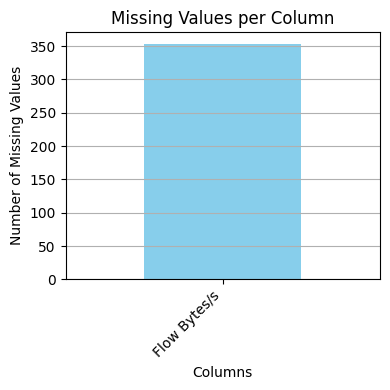


Filling missing values with median values...

Missing values after filling with median:
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

Data shape after filling missing values: (2522362, 79)


In [14]:
# Initial data shape
print(f"Initial data shape: {data.shape}")

# Checking missing values per column
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100

print("\nMissing values per column (count):")
print(missing_values)

print("\nMissing values per column (percentage):")
print(missing_values_percentage)

# Plotting missing values
missing_values = missing_values[missing_values > 0]  # Only columns with missing values
missing_values_percentage = missing_values_percentage[missing_values_percentage > 0]

if not missing_values.empty:
    plt.figure(figsize=(4, 4))
    missing_values.sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title('Missing Values per Column')
    plt.ylabel('Number of Missing Values')
    plt.xlabel('Columns')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values found. No plot needed.")

# Replacing inf values with NaN
data = data.replace([np.inf, -np.inf], np.nan)

# Checking missing values again after replacing infinities
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100

# Filling missing values with median of respective columns
print("\nFilling missing values with median values...")

for column in data.columns:
    if data[column].isnull().sum() > 0:
        median_value = data[column].median()
        data[column] = data[column].fillna(median_value)

# Checking missing values after filling
missing_values_after_filling = data.isnull().sum()

print("\nMissing values after filling with median:")
print(missing_values_after_filling)

# Verifying the data shape after filling missing values
print(f"\nData shape after filling missing values: {data.shape}")


#### 2.4. Label Corrupted Char Handling

In [15]:
unique_labels = data['Label'].unique()

print("Unique Labels:")
print(unique_labels)


Unique Labels:
['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Web Attack � Brute Force'
 'Web Attack � XSS' 'Web Attack � Sql Injection' 'Infiltration' 'Bot'
 'PortScan' 'DDoS']


In [16]:
data['Label'] = data['Label'].replace({
    'Web Attack � Brute Force': 'Web Attack - Brute Force',
    'Web Attack � XSS': 'Web Attack - XSS',
    'Web Attack � Sql Injection': 'Web Attack - Sql Injection'
})

In [17]:
unique_labels = data['Label'].unique()

print("Unique Labels after the renaming:")
print(unique_labels)


Unique Labels after the renaming:
['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Web Attack - Brute Force'
 'Web Attack - XSS' 'Web Attack - Sql Injection' 'Infiltration' 'Bot'
 'PortScan' 'DDoS']


#### 2.5. Dataset Distribution Visualization

Class Distribution:
Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack - Brute Force         1470
Web Attack - XSS                  652
Infiltration                       36
Web Attack - Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


C:\Users\burakdogan\AppData\Local\Temp\ipykernel_6528\3062753500.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


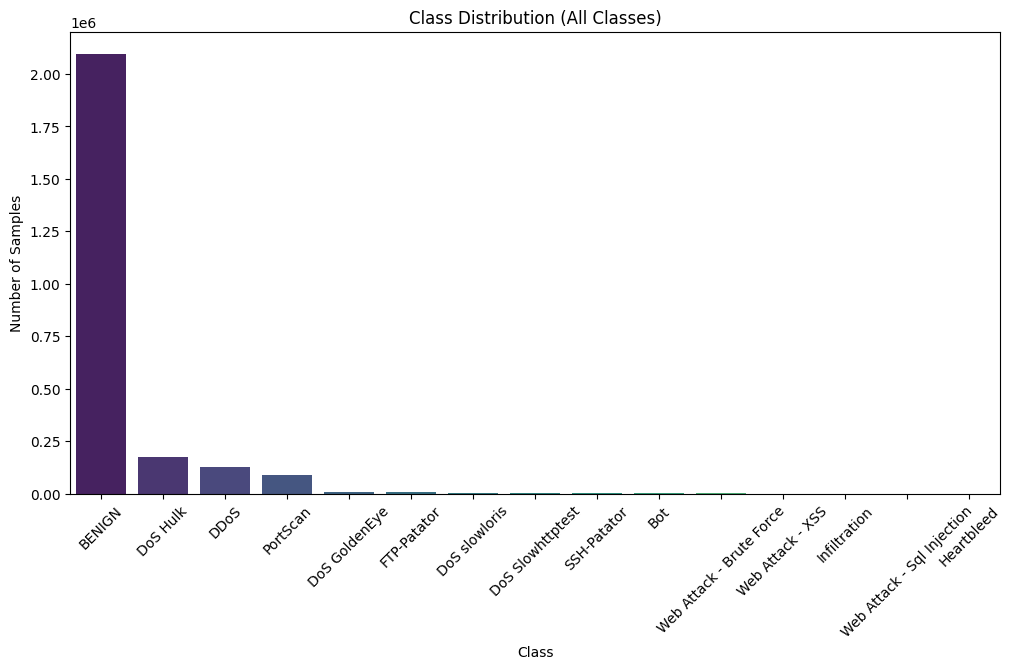

In [18]:
class_distribution = data['Label'].value_counts()
print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(12, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution (All Classes)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

Attack Type Distribution:
AttackType
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64


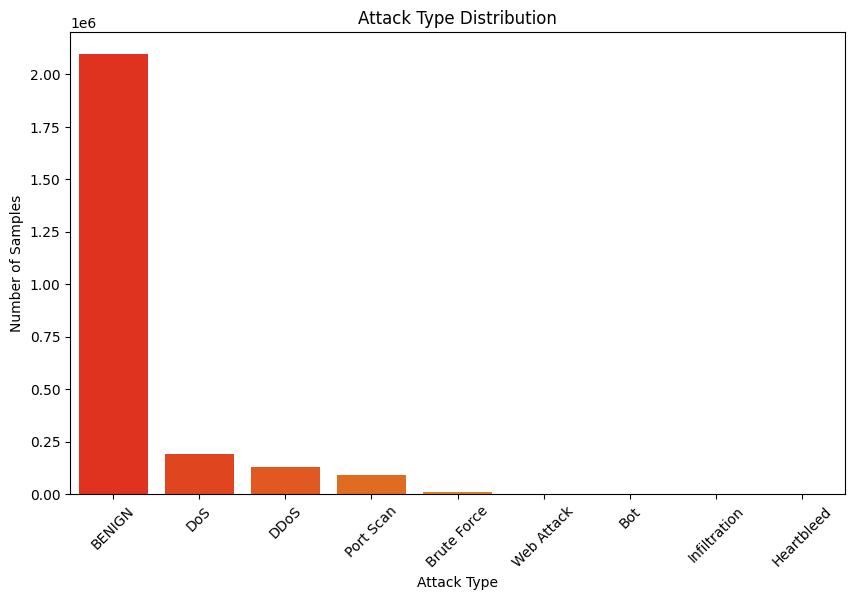

In [19]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack - Brute Force': 'Web Attack',
    'Web Attack - XSS': 'Web Attack',
    'Web Attack - Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Mapping each label to its attack type
data['AttackType'] = data['Label'].map(attack_map)

# Checking the distribution of attack types
attack_type_distribution = data['AttackType'].value_counts()
print("Attack Type Distribution:")
print(attack_type_distribution)

# Plotting the distribution of attack types
plt.figure(figsize=(10, 6))
sns.barplot(x=attack_type_distribution.index, y=attack_type_distribution.values, hue=attack_type_distribution.index, palette='autumn')
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

Binary Class Distribution:
Label
BENIGN    2096484
ATTACK     425878
Name: count, dtype: int64


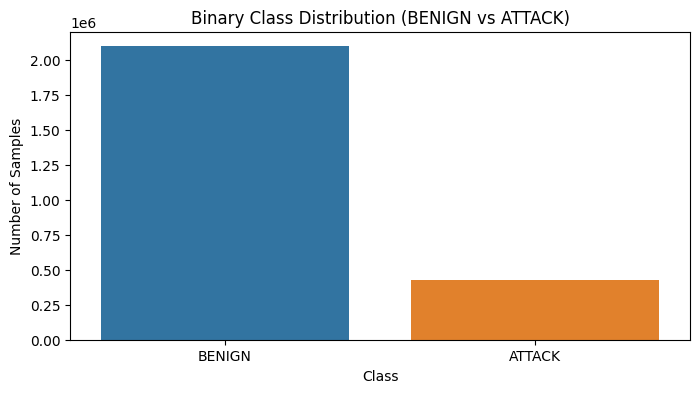

In [20]:
binary_labels = data['Label'].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')

binary_class_distribution = binary_labels.value_counts()
print("Binary Class Distribution:")
print(binary_class_distribution)

plt.figure(figsize=(8, 4))
sns.barplot(
    x=binary_class_distribution.index,
    y=binary_class_distribution.values,
    hue=binary_class_distribution.index,
    dodge=False
)
plt.legend([], [], frameon=False) 
plt.title('Binary Class Distribution (BENIGN vs ATTACK)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

#### 2.6. Correlation Matrix

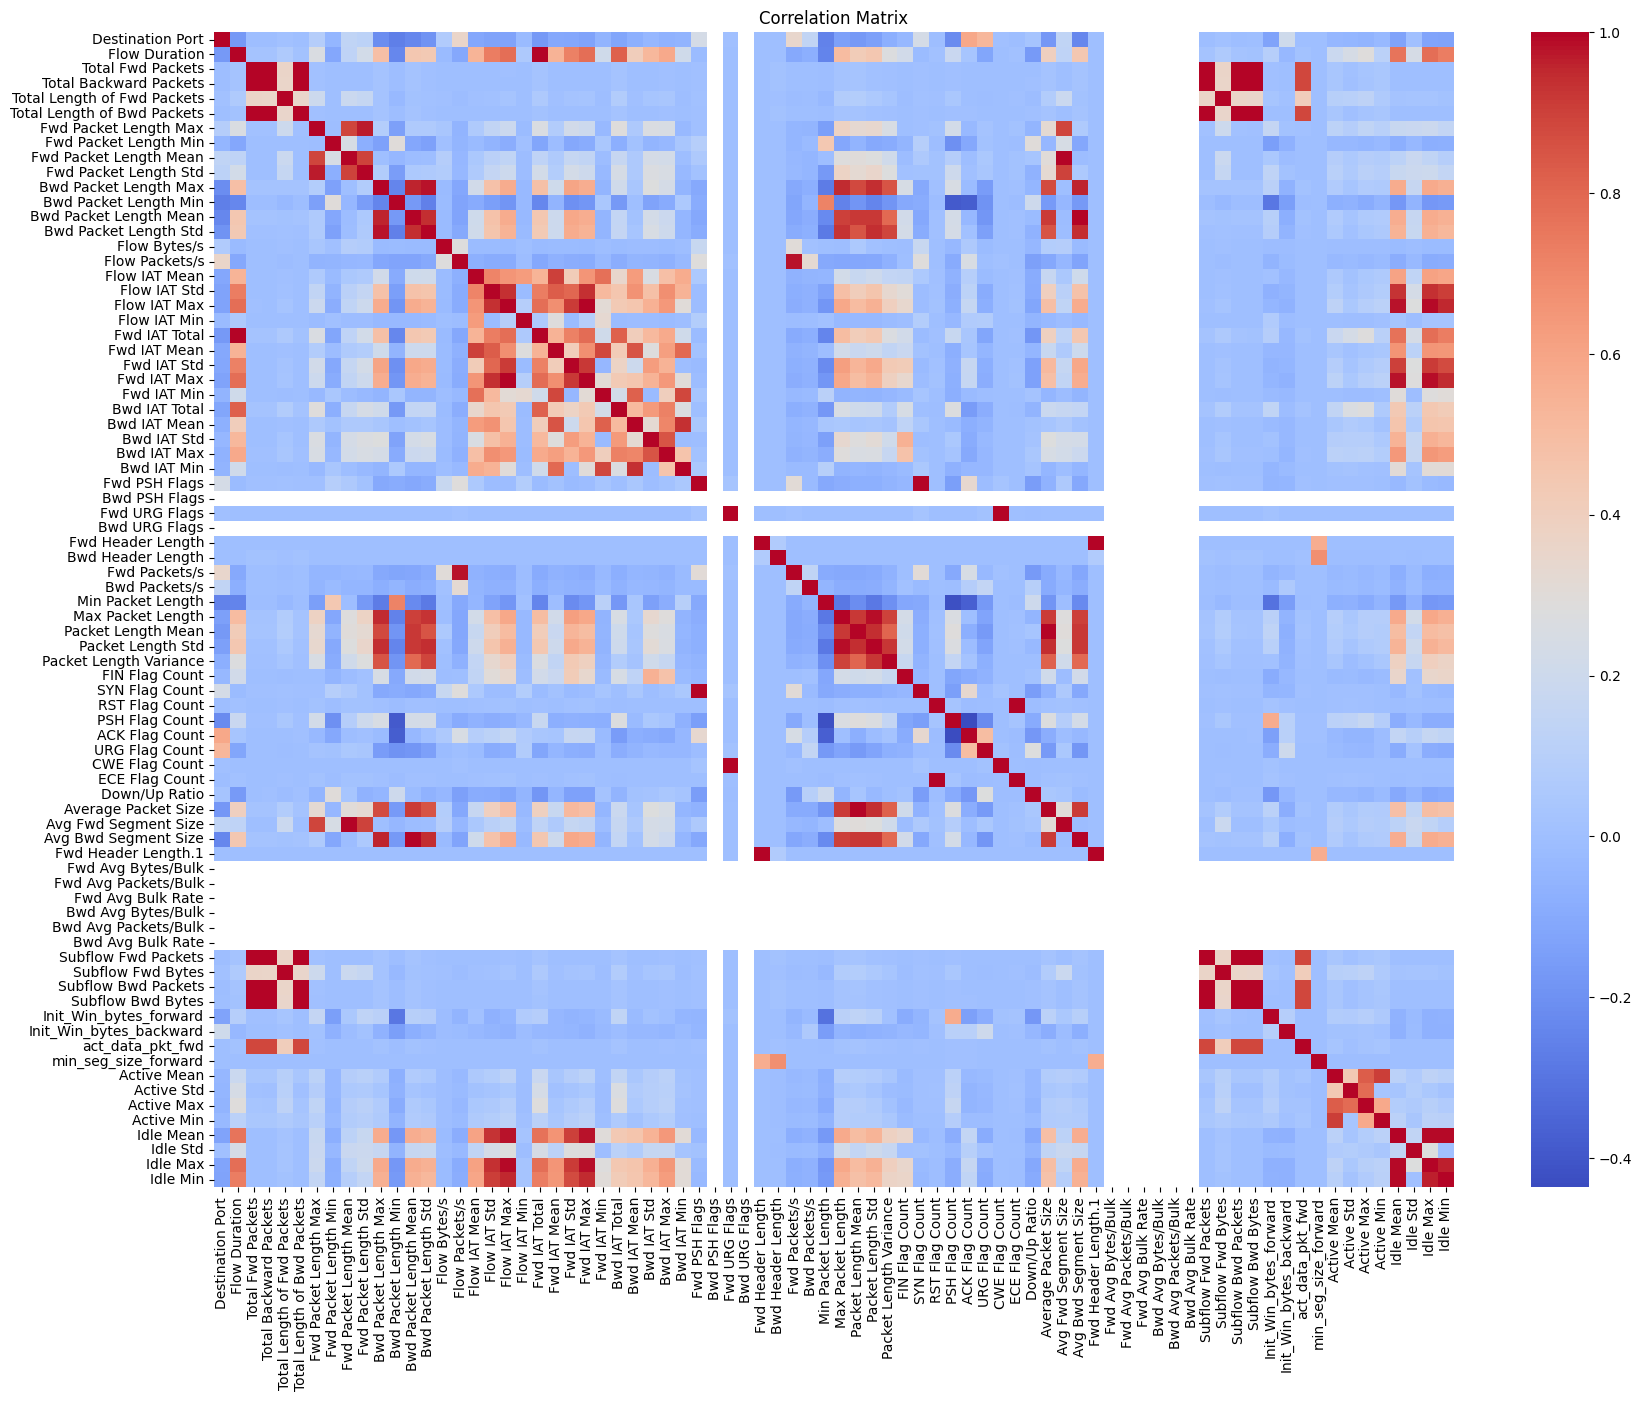

In [21]:
# Selecting numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Plotting correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(numeric_data.corr(), cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### 2.7. Feature Selection Based On Correlation

In [22]:
# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Select columns with correlation higher than 0.6 (absolute value)
high_corr_var = np.where(np.abs(corr_matrix) > 0.6)

# Get the pairs of features that have high correlation
high_corr_pairs = []
for i in range(len(high_corr_var[0])):
    if high_corr_var[0][i] != high_corr_var[1][i]:
        high_corr_pairs.append((numeric_data.columns[high_corr_var[0][i]], numeric_data.columns[high_corr_var[1][i]]))

# Display the highly correlated pairs
print("Highly correlated feature pairs:")
for pair in high_corr_pairs:
    print(pair)

# Drop one of each pair with high correlation (keeping the first column in each pair)
to_drop = set()
for pair in high_corr_pairs:
    to_drop.add(pair[1])  # Drop the second feature in each pair

# Removing highly correlated features from the dataset
numeric_data_reduced = numeric_data.drop(columns=to_drop)

# Displaying the shape after reduction
print(f"\nShape after feature selection: {numeric_data_reduced.shape}")


Highly correlated feature pairs:
('Flow Duration', 'Flow IAT Std')
('Flow Duration', 'Flow IAT Max')
('Flow Duration', 'Fwd IAT Total')
('Flow Duration', 'Fwd IAT Std')
('Flow Duration', 'Fwd IAT Max')
('Flow Duration', 'Bwd IAT Total')
('Flow Duration', 'Idle Mean')
('Flow Duration', 'Idle Max')
('Flow Duration', 'Idle Min')
('Total Fwd Packets', 'Total Backward Packets')
('Total Fwd Packets', 'Total Length of Bwd Packets')
('Total Fwd Packets', 'Subflow Fwd Packets')
('Total Fwd Packets', 'Subflow Bwd Packets')
('Total Fwd Packets', 'Subflow Bwd Bytes')
('Total Fwd Packets', 'act_data_pkt_fwd')
('Total Backward Packets', 'Total Fwd Packets')
('Total Backward Packets', 'Total Length of Bwd Packets')
('Total Backward Packets', 'Subflow Fwd Packets')
('Total Backward Packets', 'Subflow Bwd Packets')
('Total Backward Packets', 'Subflow Bwd Bytes')
('Total Backward Packets', 'act_data_pkt_fwd')
('Total Length of Fwd Packets', 'Subflow Fwd Bytes')
('Total Length of Bwd Packets', 'Total Fwd

In [23]:
remaining_columns = numeric_data_reduced.columns
print("Remaining columns after removing highly correlated features:")
print(remaining_columns)
print(remaining_columns.shape)

Remaining columns after removing highly correlated features:
Index(['Destination Port', 'Fwd Packet Length Min', 'Flow Bytes/s',
       'Bwd PSH Flags', 'Bwd URG Flags', 'Bwd Packets/s', 'FIN Flag Count',
       'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Idle Std'],
      dtype='object')
(20,)


In [24]:
numeric_data_reduced.head(10)

,Destination Port,Fwd Packet Length Min,Flow Bytes/s,Bwd PSH Flags,Bwd URG Flags,Bwd Packets/s,FIN Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,Idle Std
0,49188,6,3.000000e+06,0,0,0.000000,0,0,1,1,0,0,0,0,0,0,0,329,-1,0.0
1,49188,6,1.200000e+07,0,0,0.000000,0,0,1,1,0,0,0,0,0,0,0,329,-1,0.0
4,49486,6,4.000000e+06,0,0,0.000000,0,0,1,1,0,0,0,0,0,0,0,245,-1,0.0
5,49486,6,1.200000e+07,0,0,0.000000,0,0,1,1,0,0,0,0,0,0,0,245,-1,0.0
8,88,0,1.474548e+06,0,0,6568.144499,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0
9,88,0,4.232082e+06,0,0,4550.625711,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0
10,88,0,5.329310e+06,0,0,5172.413793,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0
11,88,0,1.074809e+07,0,0,7633.587786,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0
12,1034,6,2.000000e+06,0,0,166666.666667,0,0,1,0,1,0,0,0,0,0,0,2053,251,0.0
13,88,0,5.558534e+06,0,0,5361.930295,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0


## 3. Binary Classification (Attack & Benign)

#### 3.1. Data Preparing and Sampling

In [25]:
# Separate features and labels
X = numeric_data_reduced.reset_index(drop=True)  # Numerical features
y = data['Label'].reset_index(drop=True)  # Labels

# Map labels: 'BENIGN' -> 0, attacks -> 1
y_binary = y.apply(lambda x: 0 if x == 'BENIGN' else 1)

# Create masks for attack and benign classes
attack_mask = (y_binary == 1)
benign_mask = (y_binary == 0)

# Apply RandomUnderSampler only on attack classes with custom sampling strategy
rus = RandomUnderSampler(sampling_strategy=lambda y: {label: min(1200, sum(y == label)) for label in np.unique(y)}, random_state=42)

# Apply undersampling only on attack data
X_attack = X[attack_mask]
y_attack = y[attack_mask]
X_attack_resampled, y_attack_resampled = rus.fit_resample(X_attack, y_attack)

# For benign, sample 12000 instances randomly
X_benign = X[benign_mask].sample(n=12000, random_state=42)
y_benign = y[benign_mask].loc[X_benign.index]

# Combine attack and benign data into a balanced dataset
X_balanced = pd.concat([X_benign, X_attack_resampled], axis=0).reset_index(drop=True)
y_balanced = pd.concat([y_benign, y_attack_resampled], axis=0).reset_index(drop=True)

# Re-map labels: 'BENIGN' -> 0, attacks -> 1
y_balanced = y_balanced.apply(lambda x: 0 if x == 'BENIGN' else 1)

#### 3.2. Train Test Split

In [26]:
# Split into train and test sets first
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2, random_state=42, stratify=y_balanced
)

#### 3.3. Scaling

In [27]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 3.4. Visualization

In [28]:
# Print summary after scaling
print(f"\nTrain set shape: {X_train_scaled.shape}, Test set shape: {X_test_scaled.shape}")
print("\nTrain set class distribution:")
print(pd.Series(y_train).value_counts())

print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts())


Train set shape: (19776, 20), Test set shape: (4944, 20)

Train set class distribution:
Label
1    10176
0     9600
Name: count, dtype: int64

Test set class distribution:
Label
1    2544
0    2400
Name: count, dtype: int64


#### 3.4. Define Models

In [29]:
# Define models
binary_models = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('SVM', SVC(C=0.5, random_state=42)),
    ('Logistic Regression', LogisticRegression(C=0.5, random_state=42, max_iter=10000)),
    ('KNN', KNeighborsClassifier(n_neighbors=5, algorithm='auto')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5))
]

#### 3.5. Train and Compare

In [30]:
def train_and_compare(models, X_train, y_train, cv_splits=5, save_dir='model_logs', problem_type='binary'):
    """
    Generic function to train and compare models for both binary and multiclass classification
    
    Args:
        models: List of (name, model) tuples
        X_train, y_train: Training data
        cv_splits: Number of cross-validation folds
        save_dir: Directory to save results
        problem_type: 'binary' or 'multiclass'
    """
    os.makedirs(save_dir, exist_ok=True)
    results = {}
    trained_models = {}
    
    # Define scoring based on problem type
    if problem_type == 'binary':
        scoring = ['accuracy', 'f1', 'precision', 'recall']
    else:
        scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
    
    for name, model in models:
        print(f"\n{'='*50}\nEvaluating {name}\n{'='*50}")
        start_time = time.time()
        
        # Cross-validation
        cv_results = cross_validate(model, X_train, y_train, cv=cv_splits,
                                  scoring=scoring, return_train_score=False)
        
        # Extract metrics with proper key names
        metrics = {
            'accuracy': cv_results['test_accuracy'].mean(),
            'f1': cv_results[f'test_{scoring[1]}'].mean(),
            'precision': cv_results[f'test_{scoring[2]}'].mean(),
            'recall': cv_results[f'test_{scoring[3]}'].mean(),
            'train_time': time.time() - start_time
        }
        
        # Full training
        model.fit(X_train, y_train)
        trained_models[name] = model
        
        # Train set predictions
        y_pred = model.predict(X_train)
        y_proba = model.predict_proba(X_train) if hasattr(model, "predict_proba") else None
        
        # Classification report
        print(f"\nClassification Report for {name} on Train Set:")
        print(classification_report(y_train, y_pred))
        
        # ROC Curve if available
        if y_proba is not None:
            if problem_type == 'binary':
                # Binary sınıfların isimlerini al
                class_names = np.unique(y_train)
                
                fpr, tpr, _ = roc_curve(y_train, y_proba[:, 1], pos_label=class_names[1])
                roc_auc = auc(fpr, tpr)
                
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='blue', lw=2, 
                        label=f'ROC Curve (AUC = {roc_auc:.2f})\nPositive: {class_names[1]}')
                plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
                
                plt.xlabel(f'False Positive Rate\n(Negative: {class_names[0]})')
                plt.ylabel(f'True Positive Rate\n(Positive: {class_names[1]})')
                plt.title(f'ROC Curve - {name}')
                
                plt.legend(loc="lower right", frameon=True)
                plt.grid(True, alpha=0.3)
                
                plt.text(0.6, 0.2, f'AUC: {roc_auc:.3f}',
                        bbox=dict(facecolor='white', alpha=0.8))
                
                plt.tight_layout()
                plt.show()            
            elif problem_type == 'multiclass':
                n_classes = len(np.unique(y_train))
                if n_classes > 2:
                    classes = np.unique(y_train)
                    y_train_bin = label_binarize(y_train, classes=classes)
                    
                    fpr = dict()
                    tpr = dict()
                    roc_auc = dict()
                    
                    plt.figure(figsize=(10, 8))
                    
                    for i, class_name in enumerate(classes):
                        fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_proba[:, i])
                        roc_auc[i] = auc(fpr[i], tpr[i])
                        
                        plt.plot(fpr[i], tpr[i], 
                                label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
                    
                    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title(f'Multiclass ROC Curves - {name}')
                    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()
        
        results[name] = metrics
    
    # Comparative Analysis
    results_df = pd.DataFrame(results).T
    print("\nComparative Performance Metrics:")
    display(results_df)
    
    # Plotting comparison
    plt.figure(figsize=(12, 6))
    results_df[['accuracy', 'f1', 'precision', 'recall']].plot(kind='bar', colormap='viridis')
    plt.title('Model Comparison - Training Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df.to_csv(os.path.join(save_dir, f'{problem_type}_model_comparison.csv'))
    
    return trained_models, results_df


Evaluating Random Forest

Classification Report for Random Forest on Train Set:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      9600
           1       0.97      1.00      0.99     10176

    accuracy                           0.98     19776
   macro avg       0.99      0.98      0.98     19776
weighted avg       0.99      0.98      0.98     19776



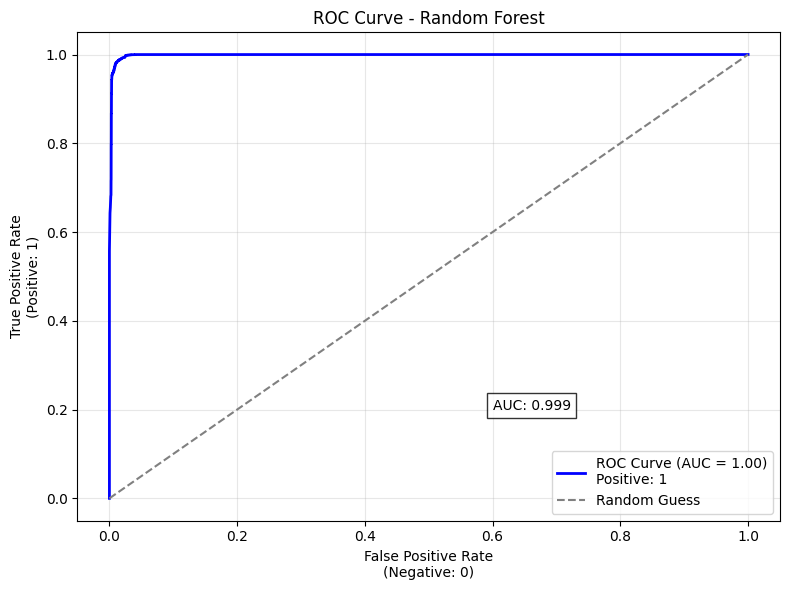


Evaluating SVM

Classification Report for SVM on Train Set:
              precision    recall  f1-score   support

           0       0.92      0.15      0.26      9600
           1       0.55      0.99      0.71     10176

    accuracy                           0.58     19776
   macro avg       0.74      0.57      0.49     19776
weighted avg       0.73      0.58      0.49     19776


Evaluating Logistic Regression

Classification Report for Logistic Regression on Train Set:
              precision    recall  f1-score   support

           0       0.75      0.69      0.71      9600
           1       0.72      0.78      0.75     10176

    accuracy                           0.73     19776
   macro avg       0.74      0.73      0.73     19776
weighted avg       0.73      0.73      0.73     19776



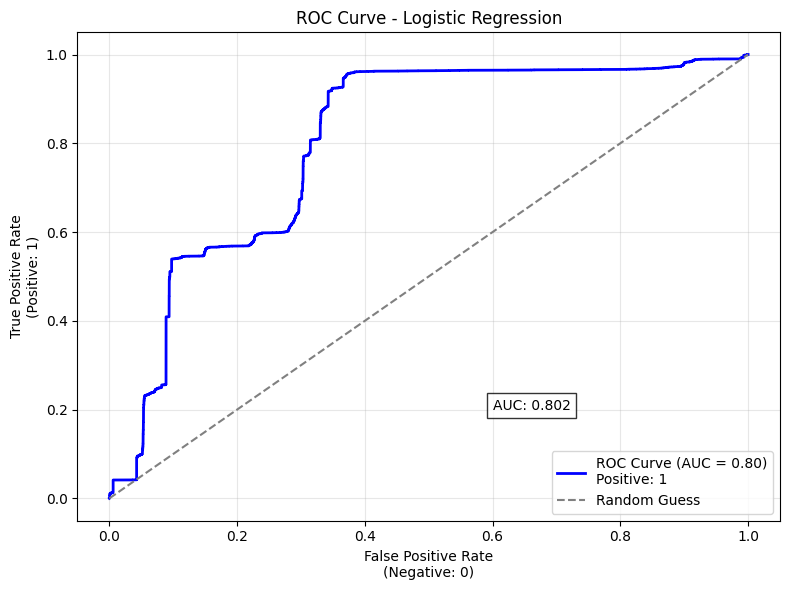


Evaluating KNN

Classification Report for KNN on Train Set:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      9600
           1       0.96      0.97      0.96     10176

    accuracy                           0.96     19776
   macro avg       0.96      0.96      0.96     19776
weighted avg       0.96      0.96      0.96     19776



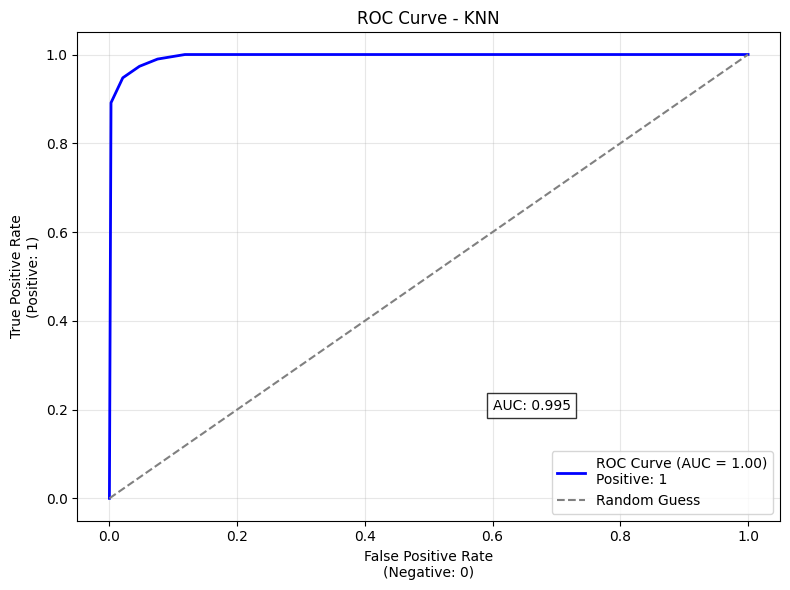


Evaluating Decision Tree

Classification Report for Decision Tree on Train Set:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9600
           1       0.98      0.99      0.98     10176

    accuracy                           0.98     19776
   macro avg       0.98      0.98      0.98     19776
weighted avg       0.98      0.98      0.98     19776



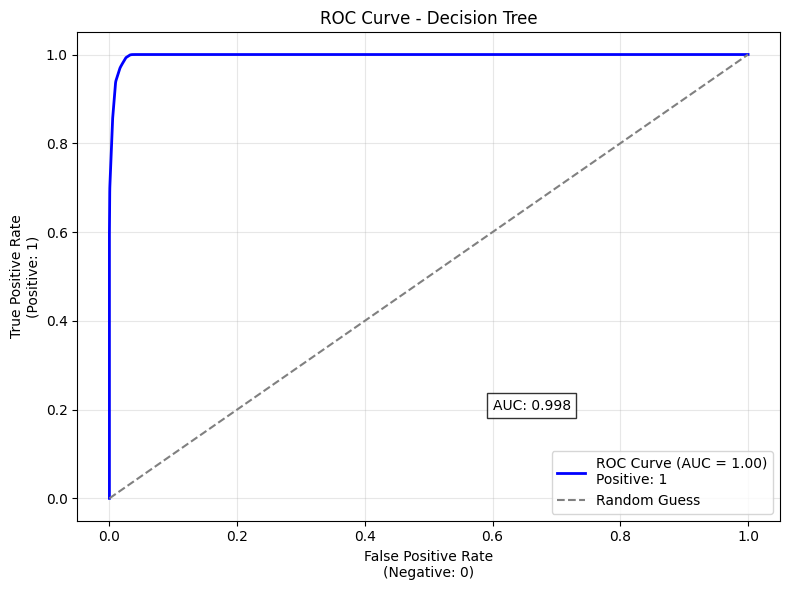


Comparative Performance Metrics:


,accuracy,f1,precision,recall,train_time
Random Forest,0.983313,0.983996,0.971469,0.996855,3.237964
SVM,0.578024,0.706650,0.550115,0.987716,39.974607
Logistic Regression,0.764967,0.789060,0.729584,0.862417,4.409378
KNN,0.947816,0.949834,0.939907,0.960005,0.855134
Decision Tree,0.979874,0.980670,0.969963,0.991647,0.174197


<Figure size 1200x600 with 0 Axes>

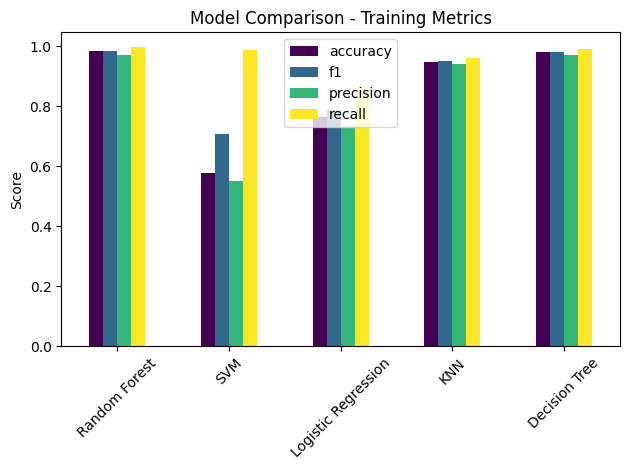

In [31]:
trained_models, results = train_and_compare(binary_models, X_train, y_train, problem_type='binary')

#### 3.6. Evaluate Best Model

In [32]:
def evaluate_on_test(trained_models, X_test, y_test, metric='f1', save_dir='model_logs', problem_type='binary'):
    """
    Generic function to evaluate best model on test set for both binary and multiclass
    
    Args:
        trained_models: Dictionary of trained models
        X_test, y_test: Test data
        metric: Metric to select best model
        save_dir: Directory to save results
        problem_type: 'binary' or 'multiclass'
    """
    # Load comparison results
    results_df = pd.read_csv(os.path.join(save_dir, f'{problem_type}_model_comparison.csv'), index_col=0)
    
    # Select best model based on the specified metric
    best_model_name = results_df[metric].idxmax()
    best_model = trained_models[best_model_name]
    
    print(f"\n{'='*50}\nEvaluating BEST MODEL ({best_model_name}) on TEST SET\n{'='*50}")
    
    # Test set predictions
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None
    predict_time = time.time() - start_time
    
    # Classification report
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix visualization
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.show()
    
    # ROC Curve visualization if available
    if y_proba is not None:
        if problem_type == 'binary':
            fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Test Set ROC - {best_model_name}')
            plt.legend()
            plt.show()
            
        elif problem_type == 'multiclass':
            n_classes = len(np.unique(y_test))
            if n_classes > 2:
                y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
                
                # Compute ROC curve and ROC area for each class
                fpr = dict()
                tpr = dict()
                roc_auc = dict()
                for i in range(n_classes):
                    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
                
                # Plot all ROC curves
                plt.figure()
                for i in range(n_classes):
                    plt.plot(fpr[i], tpr[i], 
                             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
                
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'Multiclass ROC Curves - {best_model_name}')
                plt.legend()
                plt.show()
    
    # Feature Importance visualization (for models that support it)
    if hasattr(best_model, 'feature_importances_'):
        importances = pd.Series(best_model.feature_importances_, index=X_test.columns)
        importances.sort_values().plot(kind='barh', title='Feature Importances')
        plt.show()
    
    # Save the best model to disk
    os.makedirs(save_dir, exist_ok=True)
    best_model_filename = f'best_model_{problem_type}_{best_model_name.replace(" ", "_")}.pkl'
    best_model_path = os.path.join(save_dir, best_model_filename)
    joblib.dump(best_model, best_model_path)
    print(f"\n✔ Best model '{best_model_name}' successfully saved to: {best_model_path}")
    print(f"⏱ Prediction time on test set: {predict_time:.4f} seconds")


Evaluating BEST MODEL (Random Forest) on TEST SET

Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2400
           1       0.97      1.00      0.98      2544

    accuracy                           0.98      4944
   macro avg       0.98      0.98      0.98      4944
weighted avg       0.98      0.98      0.98      4944



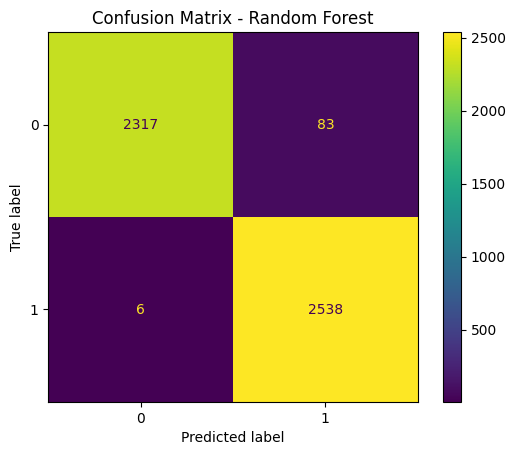

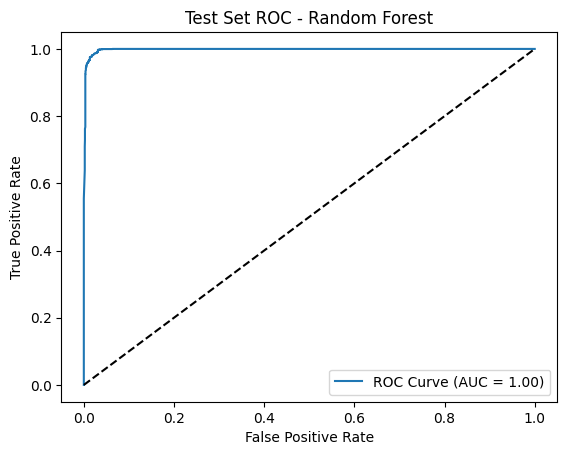

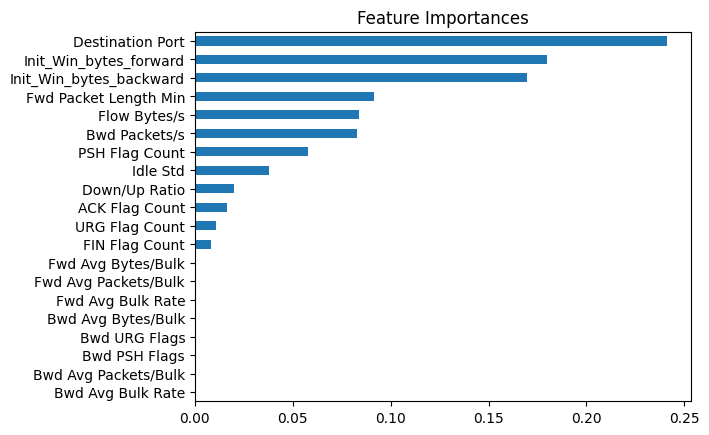


✔ Best model 'Random Forest' successfully saved to: model_logs\best_model_binary_Random_Forest.pkl
⏱ Prediction time on test set: 0.0549 seconds


In [33]:
evaluate_on_test(trained_models, X_test, y_test, problem_type='binary')

## 4. Multi-class Attack Classification

#### 4.1.Prepare the Data and Split Features and Labels

In [34]:
# Create a copy of the dataset with 'Label' as the target column
X_all = numeric_data_reduced.copy()
X_all['Label'] = data['Label'].values  

# Filter out the 'BENIGN' class and reset the index
attack_data = X_all[X_all['Label'] != 'BENIGN'].reset_index(drop=True)

# Remove the specified attack types directly from attack_data
attack_data = attack_data[~attack_data['Label'].isin(['Infiltration', 'Web Attack - Sql Injection', 'Heartbleed'])]

# Split the data into features (X) and labels (y)
X_attack = attack_data.drop(columns=['Label'])
y_attack = attack_data['Label']

# Check the shapes and distribution of attack types
print(f"X_attack shape: {X_attack.shape}")
print(f"y_attack shape: {y_attack.shape}")
print("\nFiltered Attack type distribution:")
print(y_attack.value_counts())


X_attack shape: (425810, 20)
y_attack shape: (425810,)

Filtered Attack type distribution:
Label
DoS Hulk                    172849
DDoS                        128016
PortScan                     90819
DoS GoldenEye                10286
FTP-Patator                   5933
DoS slowloris                 5385
DoS Slowhttptest              5228
SSH-Patator                   3219
Bot                           1953
Web Attack - Brute Force      1470
Web Attack - XSS               652
Name: count, dtype: int64


#### 4.2. Under Sampling

In [35]:
attack_counts = y_attack.value_counts()
sampling_strategy = {}

for label, count in attack_counts.items():
    if count > 3000:
        sampling_strategy[label] = 3000
    else:
        sampling_strategy[label] = count

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_attack_balanced, y_attack_balanced = rus.fit_resample(X_attack, y_attack)

print(f"\nX_attack_balanced shape: {X_attack_balanced.shape}")
print(f"y_attack_balanced shape: {y_attack_balanced.shape}")
print("\nBalanced attack type distribution:")
print(pd.Series(y_attack_balanced).value_counts())


X_attack_balanced shape: (28075, 20)
y_attack_balanced shape: (28075,)

Balanced attack type distribution:
Label
DDoS                        3000
DoS GoldenEye               3000
DoS Hulk                    3000
DoS Slowhttptest            3000
DoS slowloris               3000
FTP-Patator                 3000
PortScan                    3000
SSH-Patator                 3000
Bot                         1953
Web Attack - Brute Force    1470
Web Attack - XSS             652
Name: count, dtype: int64


#### 4.3. Train Test Splitting

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_attack_balanced, y_attack_balanced, 
    test_size=0.2, random_state=42, stratify=y_attack_balanced
)

#### 4.4. SMOTE for Train Class Balancing

In [37]:
smote_target_counts = {label: 2400 for label in y_train.unique()}

smote = SMOTE(sampling_strategy=smote_target_counts, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nX_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")


X_train_resampled shape: (26400, 20)
y_train_resampled shape: (26400,)


#### 4.5. Scaling

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
print(f"\nX_train_scaled shape: {X_train.shape}, X_test_scaled shape: {X_test.shape}")



X_train_scaled shape: (22460, 20), X_test_scaled shape: (5615, 20)


In [39]:
print("\nTrain set class distribution:")
print(pd.Series(y_train_resampled).value_counts())

print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts())


Train set class distribution:
Label
DDoS                        2400
PortScan                    2400
DoS slowloris               2400
DoS Hulk                    2400
FTP-Patator                 2400
SSH-Patator                 2400
DoS Slowhttptest            2400
DoS GoldenEye               2400
Web Attack - Brute Force    2400
Web Attack - XSS            2400
Bot                         2400
Name: count, dtype: int64

Test set class distribution:
Label
DoS slowloris               600
DoS Hulk                    600
DoS GoldenEye               600
DoS Slowhttptest            600
DDoS                        600
PortScan                    600
SSH-Patator                 600
FTP-Patator                 600
Bot                         391
Web Attack - Brute Force    294
Web Attack - XSS            130
Name: count, dtype: int64


#### 4.6. Visualization

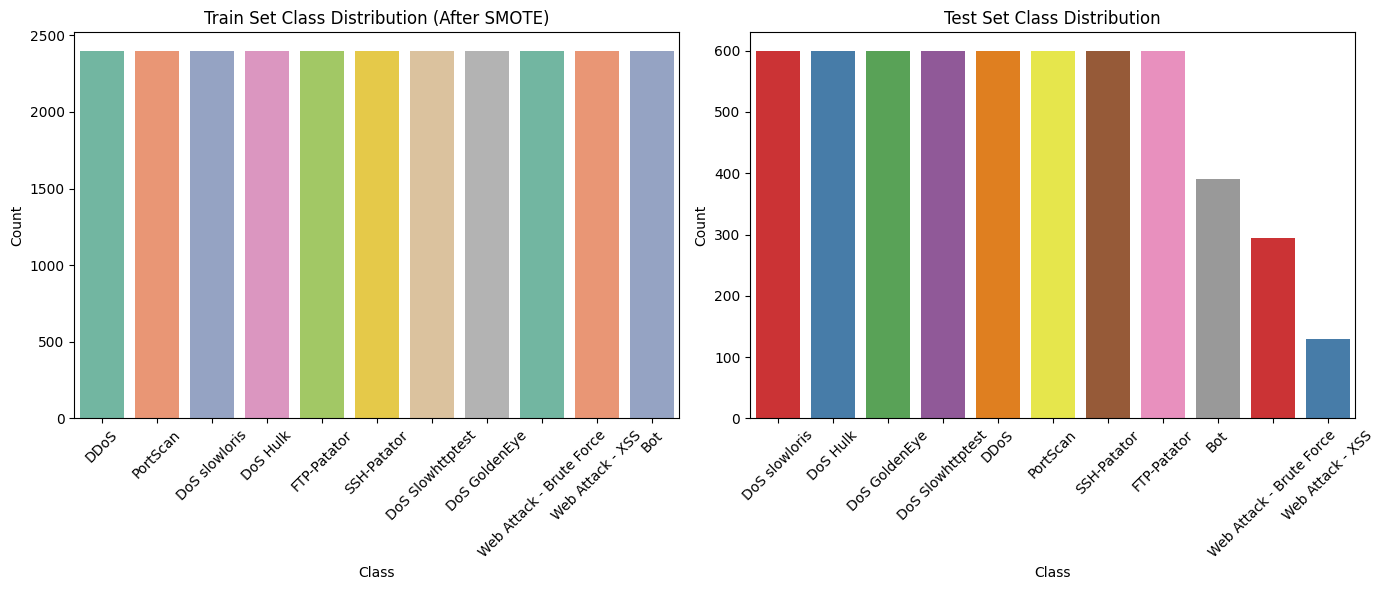

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x=y_train_resampled, ax=axes[0], hue=y_train_resampled, palette='Set2')
axes[0].set_title("Train Set Class Distribution (After SMOTE)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x=y_test, ax=axes[1], hue=y_test, palette='Set1')
axes[1].set_title("Test Set Class Distribution")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 4.6. Define the Models

In [41]:
multiclass_models = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('SVM', SVC(C=0.5, random_state=42, max_iter=10000)),
    ('Logistic Regression', LogisticRegression(C=0.5, max_iter=10000)),
    ('KNN', KNeighborsClassifier(n_neighbors=5, algorithm='auto')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)),
    ('AdaBoostClassifier',AdaBoostClassifier(n_estimators=100, random_state=42))
]

#### 4.7. Train and Compare


Evaluating Random Forest

Classification Report for Random Forest on Train Set:
                          precision    recall  f1-score   support

                     Bot       1.00      1.00      1.00      1562
                    DDoS       1.00      1.00      1.00      2400
           DoS GoldenEye       0.99      1.00      0.99      2400
                DoS Hulk       1.00      0.99      1.00      2400
        DoS Slowhttptest       0.99      0.99      0.99      2400
           DoS slowloris       0.99      0.99      0.99      2400
             FTP-Patator       1.00      1.00      1.00      2400
                PortScan       1.00      1.00      1.00      2400
             SSH-Patator       1.00      1.00      1.00      2400
Web Attack - Brute Force       0.70      1.00      0.83      1176
        Web Attack - XSS       1.00      0.04      0.07       522

                accuracy                           0.98     22460
               macro avg       0.97      0.91      0.90    

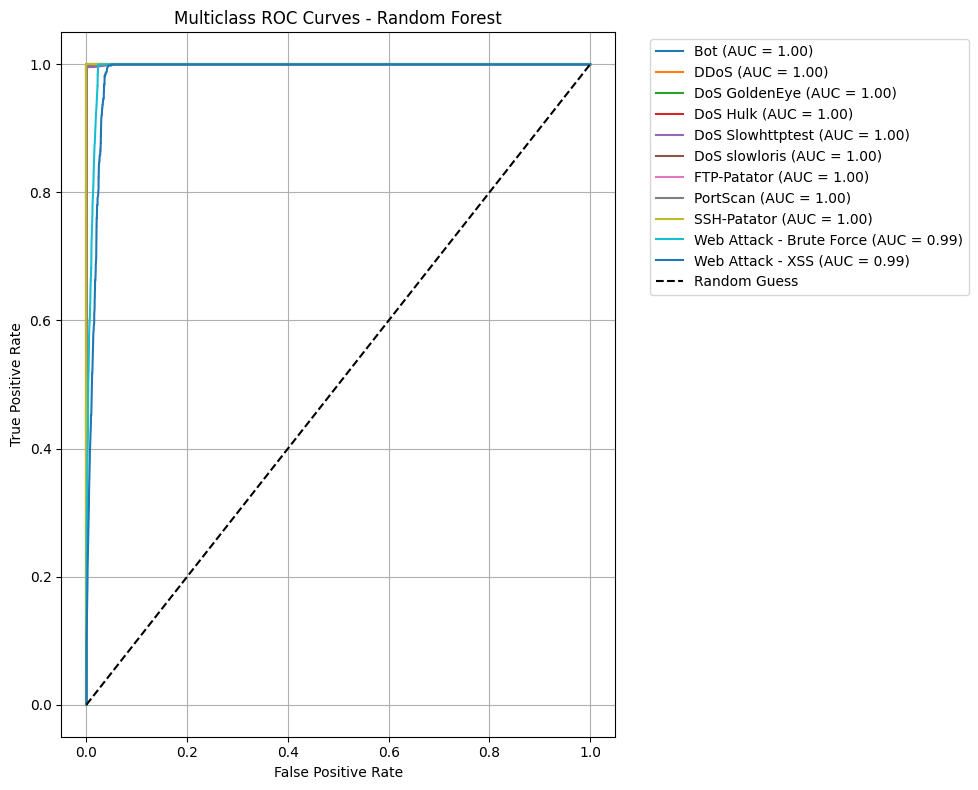


Evaluating SVM

Classification Report for SVM on Train Set:
                          precision    recall  f1-score   support

                     Bot       0.00      0.00      0.00      1562
                    DDoS       0.99      0.07      0.14      2400
           DoS GoldenEye       0.00      0.00      0.00      2400
                DoS Hulk       0.65      0.02      0.04      2400
        DoS Slowhttptest       0.96      0.55      0.70      2400
           DoS slowloris       0.89      0.32      0.47      2400
             FTP-Patator       0.00      0.00      0.00      2400
                PortScan       0.42      0.12      0.19      2400
             SSH-Patator       0.13      1.00      0.22      2400
Web Attack - Brute Force       0.00      0.00      0.00      1176
        Web Attack - XSS       0.00      0.00      0.00       522

                accuracy                           0.22     22460
               macro avg       0.37      0.19      0.16     22460
            w

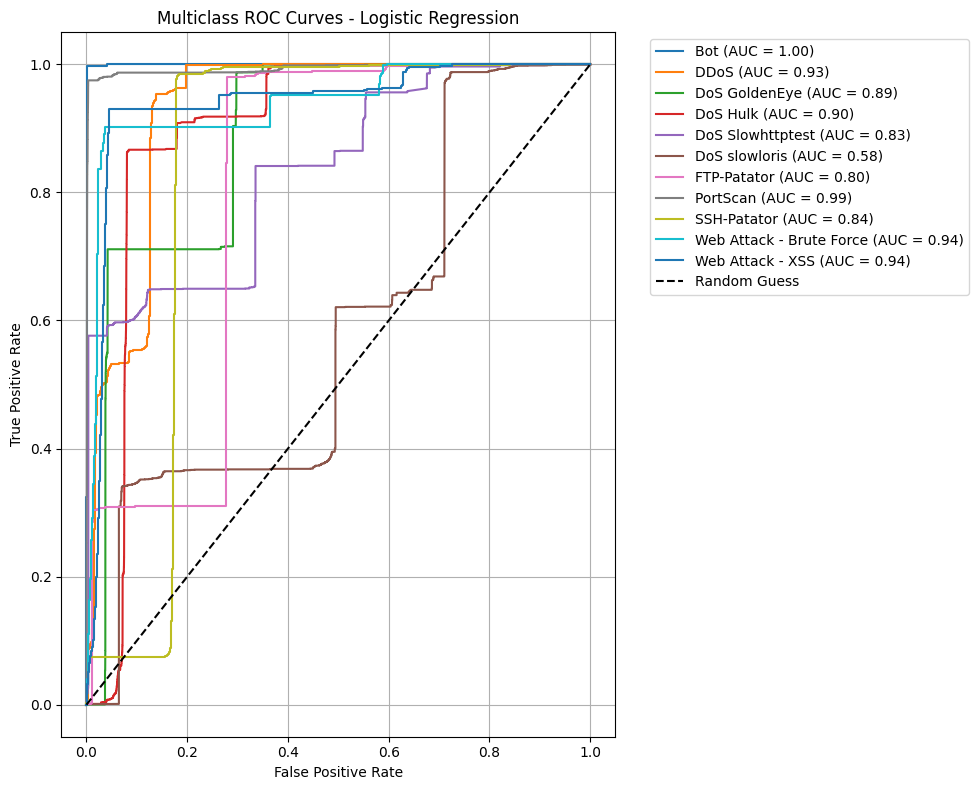


Evaluating KNN

Classification Report for KNN on Train Set:
                          precision    recall  f1-score   support

                     Bot       0.97      0.98      0.97      1562
                    DDoS       0.98      0.99      0.99      2400
           DoS GoldenEye       0.99      0.99      0.99      2400
                DoS Hulk       0.99      0.98      0.99      2400
        DoS Slowhttptest       0.98      0.97      0.98      2400
           DoS slowloris       0.98      0.96      0.97      2400
             FTP-Patator       0.99      0.99      0.99      2400
                PortScan       0.97      0.99      0.98      2400
             SSH-Patator       0.98      0.99      0.99      2400
Web Attack - Brute Force       0.75      0.77      0.76      1176
        Web Attack - XSS       0.49      0.42      0.45       522

                accuracy                           0.96     22460
               macro avg       0.92      0.91      0.91     22460
            w

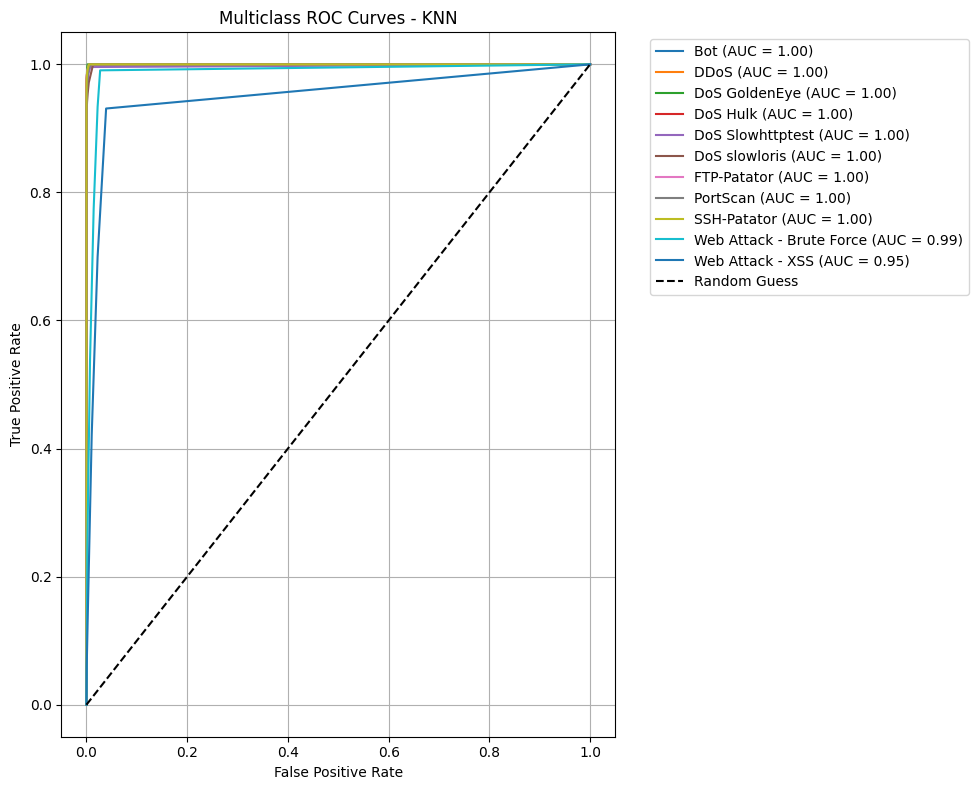


Evaluating Decision Tree

Classification Report for Decision Tree on Train Set:
                          precision    recall  f1-score   support

                     Bot       1.00      1.00      1.00      1562
                    DDoS       1.00      1.00      1.00      2400
           DoS GoldenEye       0.99      1.00      1.00      2400
                DoS Hulk       1.00      0.99      1.00      2400
        DoS Slowhttptest       1.00      0.99      0.99      2400
           DoS slowloris       0.99      0.99      0.99      2400
             FTP-Patator       1.00      1.00      1.00      2400
                PortScan       1.00      1.00      1.00      2400
             SSH-Patator       1.00      1.00      1.00      2400
Web Attack - Brute Force       0.70      0.99      0.82      1176
        Web Attack - XSS       0.83      0.08      0.15       522

                accuracy                           0.98     22460
               macro avg       0.96      0.91      0.90    

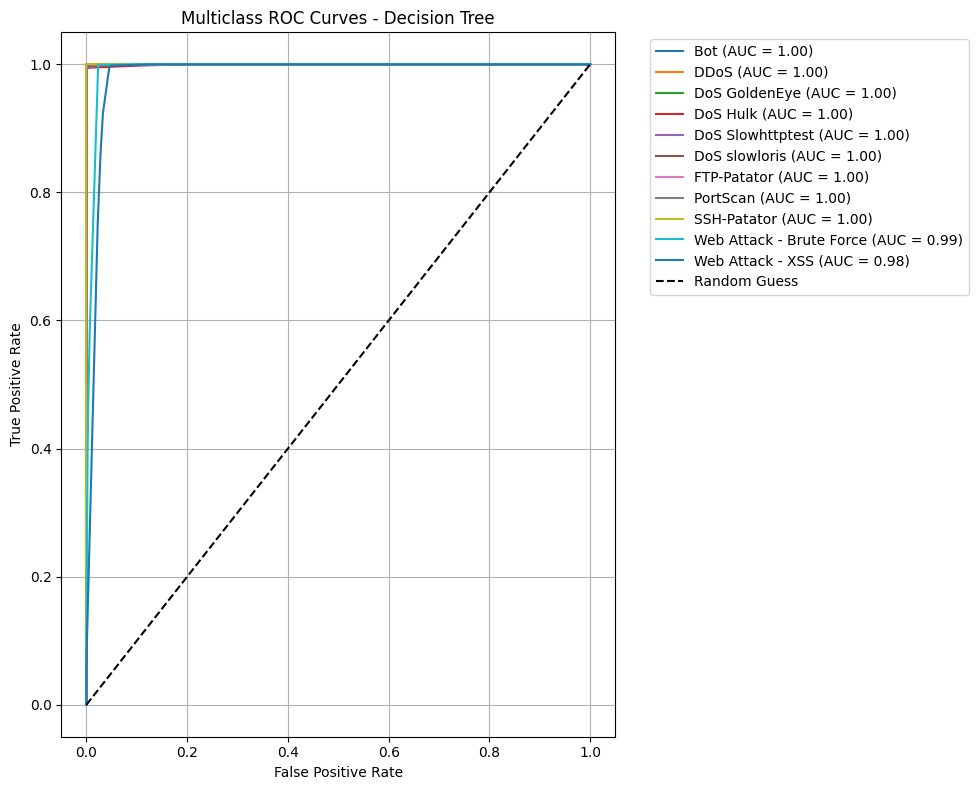


Evaluating AdaBoostClassifier

Classification Report for AdaBoostClassifier on Train Set:
                          precision    recall  f1-score   support

                     Bot       0.99      0.75      0.86      1562
                    DDoS       0.82      0.99      0.90      2400
           DoS GoldenEye       0.66      0.95      0.78      2400
                DoS Hulk       0.83      0.85      0.84      2400
        DoS Slowhttptest       0.52      0.64      0.57      2400
           DoS slowloris       0.13      0.03      0.05      2400
             FTP-Patator       0.98      0.67      0.80      2400
                PortScan       1.00      0.97      0.98      2400
             SSH-Patator       0.75      1.00      0.85      2400
Web Attack - Brute Force       0.60      0.91      0.73      1176
        Web Attack - XSS       0.33      0.00      0.00       522

                accuracy                           0.75     22460
               macro avg       0.69      0.71    

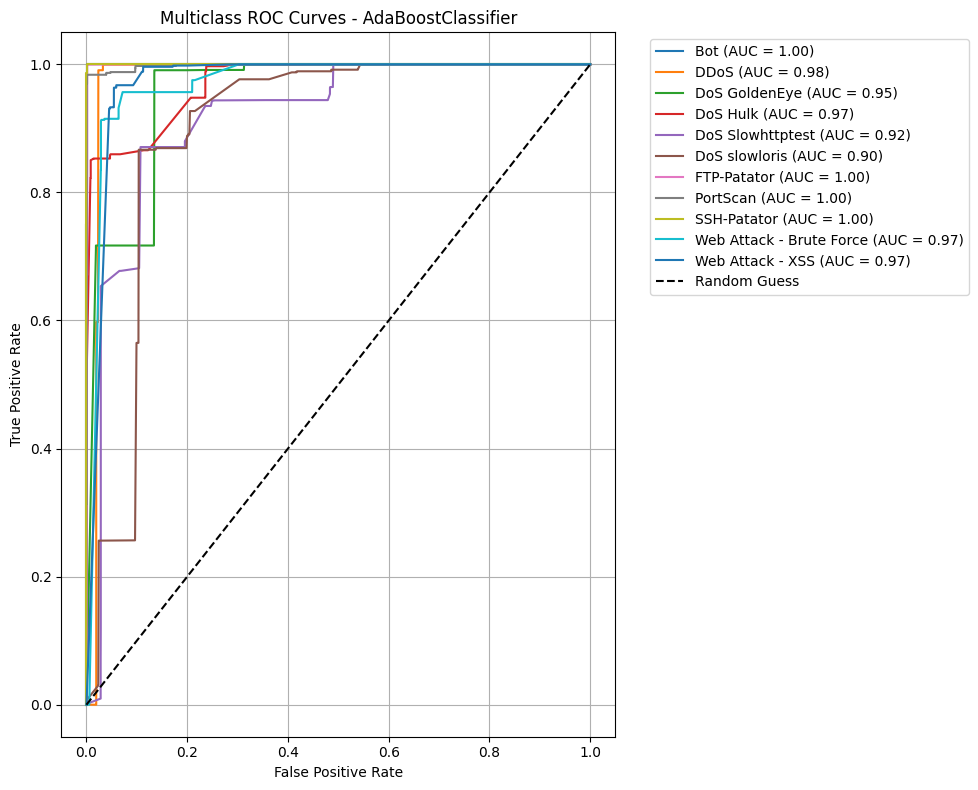


Comparative Performance Metrics:


,accuracy,f1,precision,recall,train_time
Random Forest,0.974399,0.966449,0.978599,0.974399,3.694977
SVM,0.221772,0.186093,0.447971,0.221772,72.561408
Logistic Regression,0.444969,0.349335,0.531860,0.444969,253.358119
KNN,0.947195,0.946412,0.945923,0.947195,1.024117
Decision Tree,0.971638,0.964096,0.971649,0.971638,0.412101
AdaBoostClassifier,0.695459,0.673689,0.721277,0.695459,10.269790


<Figure size 1200x600 with 0 Axes>

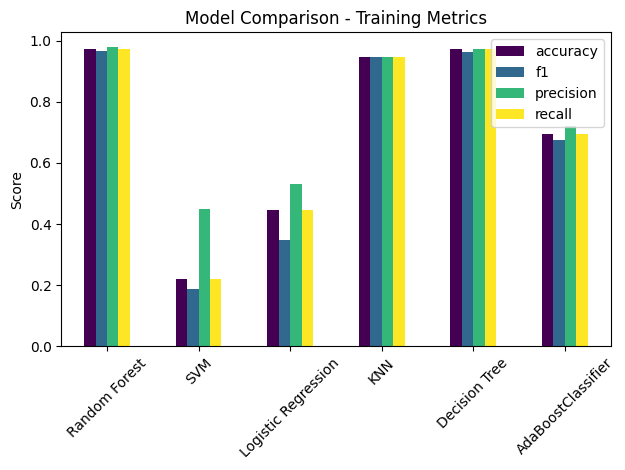

In [42]:
trained_models, results = train_and_compare(multiclass_models, X_train, y_train, problem_type='multiclass')

#### 4.8. Evaluate Best Model


Evaluating BEST MODEL (Random Forest) on TEST SET

Test Set Classification Report:
                          precision    recall  f1-score   support

                     Bot       1.00      1.00      1.00       391
                    DDoS       1.00      1.00      1.00       600
           DoS GoldenEye       0.99      1.00      0.99       600
                DoS Hulk       1.00      0.99      1.00       600
        DoS Slowhttptest       1.00      0.99      0.99       600
           DoS slowloris       0.99      0.99      0.99       600
             FTP-Patator       1.00      1.00      1.00       600
                PortScan       1.00      1.00      1.00       600
             SSH-Patator       1.00      1.00      1.00       600
Web Attack - Brute Force       0.70      0.99      0.82       294
        Web Attack - XSS       0.75      0.02      0.04       130

                accuracy                           0.97      5615
               macro avg       0.95      0.91      0.89 

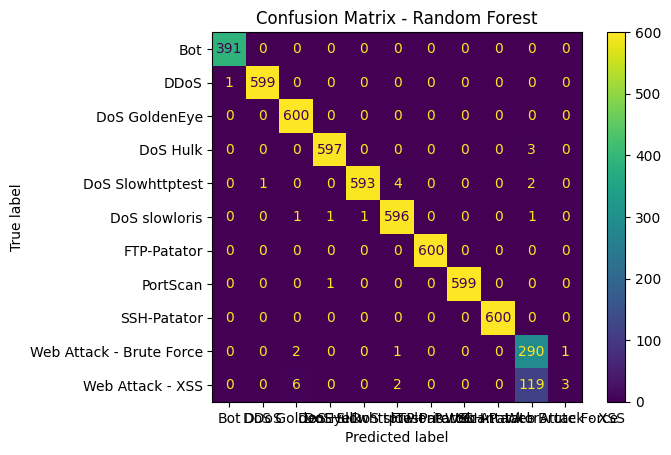

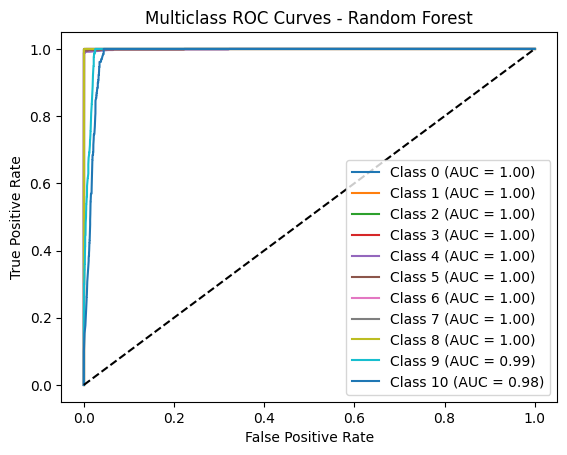

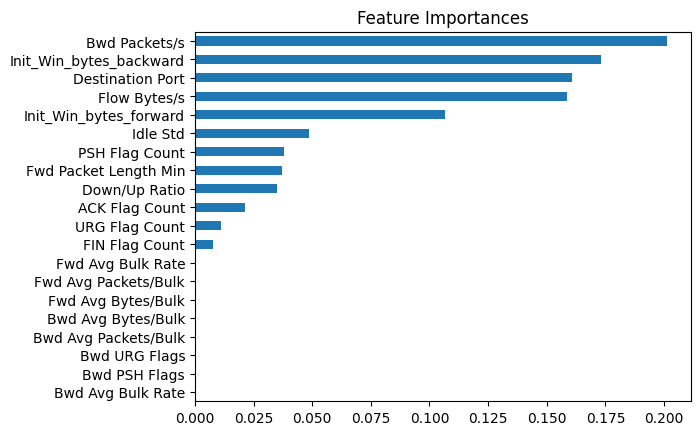


✔ Best model 'Random Forest' successfully saved to: model_logs\best_model_multiclass_Random_Forest.pkl
⏱ Prediction time on test set: 0.0667 seconds


In [43]:
evaluate_on_test(trained_models, X_test, y_test, problem_type='multiclass')